# NewsAPI

In [ ]:
import requests
import pandas as pd


# news api-key:
# 1270f9ec3e2a40f3a58f67bba8b716f4


def call_news_api():
  url = "https://newsapi.org/v2/everything"
  params = {
      "q": "bitcoin",
      "apiKey": "1270f9ec3e2a40f3a58f67bba8b716f4"
  }
  response = requests.get(url, params=params)
  if response.status_code == 200:
      data = response.json()
      print(data)
      articles = data.get("articles", [])

      # Convert to DataFrame
      df = pd.DataFrame(articles)

      # Save to file
      df.to_excel("news_articles.xlsx", index=False)
      df.to_csv("news_articles.csv", index=False)
      print("Data saved to news_articles.xlsx")
  else:
      print(f"Error: {response.status_code}", response.text)

call_news_api()


{'status': 'ok', 'totalResults': 9756, 'articles': [{'source': {'id': None, 'name': 'Gizmodo.com'}, 'author': 'Matthew Gault', 'title': 'Musk and Trump’s Fort Knox Trip Is About Bitcoin', 'description': 'More than a stunt, the Fort Knox visit might be a chance for the President to change the price of gold and dump the price hike into cryptocurrency.', 'url': 'https://gizmodo.com/musk-and-trumps-fort-knox-trip-is-about-bitcoin-2000569420', 'urlToImage': 'https://gizmodo.com/app/uploads/2024/10/sec-bitcoin-hack-arrest.jpg', 'publishedAt': '2025-02-27T19:05:24Z', 'content': 'Can a President make money out of thin air? On paper, yes.\r\nDonald Trump and Elon Musk have been talking a lot about Fort Knox lately, the place where America keeps its official gold reserves. Both h… [+3792 chars]'}, {'source': {'id': None, 'name': 'BBC News'}, 'author': None, 'title': 'Bitcoin in the bush - the crypto mine in remote Zambia', 'description': 'Bitcoin miners will go to remote locations to take advant

# Transformer

In [ ]:
# !pip install nltk
# import nltk
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import nltk
from io import StringIO

# Download NLTK tokenizer
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Langkah 1: Persiapan Data
# Memuat dataset dari string CSV yang diberikan
df = pd.read_csv('news_articles.csv')

# Pastikan kolom 'description' dan 'title' ada
df = df[['description', 'title']].dropna()

# Fungsi tokenisasi sederhana dengan NLTK
def tokenize(text):
    return word_tokenize(text.lower())

# Bangun vocabulary secara manual
def build_vocab(texts):
    vocab = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}
    idx = 4
    for text in texts:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

# Vocabulary untuk description dan title
vocab_desc = build_vocab(df['description'])
vocab_title = build_vocab(df['title'])

# Fungsi untuk mengonversi teks ke tensor
def text_to_tensor(text, vocab):
    tokens = tokenize(text)
    indices = [vocab['<bos>']] + [vocab.get(token, vocab['<unk>']) for token in tokens] + [vocab['<eos>']]
    return torch.tensor(indices, dtype=torch.long)

# Dataset khusus
class NewsDataset(Dataset):
    def __init__(self, df, vocab_desc, vocab_title):
        self.df = df
        self.vocab_desc = vocab_desc
        self.vocab_title = vocab_title

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        desc = self.df.iloc[idx]['description']
        title = self.df.iloc[idx]['title']
        desc_tensor = text_to_tensor(desc, self.vocab_desc)
        title_tensor = text_to_tensor(title, self.vocab_title)
        return desc_tensor, title_tensor

# Padding untuk batch
def collate_fn(batch):
    descs, titles = zip(*batch)
    descs_padded = pad_sequence(descs, batch_first=True, padding_value=vocab_desc['<pad>'])
    titles_padded = pad_sequence(titles, batch_first=True, padding_value=vocab_title['<pad>'])
    return descs_padded, titles_padded

# Membuat DataLoader
dataset = NewsDataset(df, vocab_desc, vocab_title)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Langkah 2: Membangun Model Transformer
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        src_emb = self.positional_encoding(self.src_embedding(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float)))
        tgt_emb = self.positional_encoding(self.tgt_embedding(tgt) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float)))
        output = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask)
        return self.fc_out(output)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Inisialisasi model
src_vocab_size = len(vocab_desc)
tgt_vocab_size = len(vocab_title)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerModel(src_vocab_size, tgt_vocab_size).to(device)

# Langkah 3: Melatih Model
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_title['<pad>'])

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def train(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            src_padding_mask = (src == vocab_desc['<pad>']).to(device)
            tgt_padding_mask = (tgt_input == vocab_title['<pad>']).to(device)
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

            optimizer.zero_grad()
            output = model(src, tgt_input, tgt_mask=tgt_mask, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
            loss = criterion(output.reshape(-1, tgt_vocab_size), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')


start_training = time.time()

train(model, dataloader, epochs=50)

end_training = time.time()
print(f"Transformer Training time: {end_training - start_training:.2f} seconds")


# Langkah 4: Menghasilkan Judul
def generate_title(model, description, vocab_title, max_len=20):
    model.eval()
    with torch.no_grad():
        src = text_to_tensor(description, vocab_desc).unsqueeze(0).to(device)
        src_padding_mask = (src == vocab_desc['<pad>']).to(device)
        tgt = torch.tensor([[vocab_title['<bos>']]], dtype=torch.long).to(device)

        for _ in range(max_len):
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            output = model(src, tgt, tgt_mask=tgt_mask, src_padding_mask=src_padding_mask)
            next_token = output[:, -1, :].argmax(dim=-1).unsqueeze(0)
            tgt = torch.cat([tgt, next_token], dim=1)
            if next_token.item() == vocab_title['<eos>']:
                break

        # Konversi kembali ke teks
        itos = {i: t for t, i in vocab_title.items()}
        title_tokens = [itos[idx] for idx in tgt[0].tolist()]
        return ' '.join([token for token in title_tokens if token not in ['<bos>', '<eos>', '<pad>']])

start_inferencing = time.time()
generated_titles = []
for i in range(len(df)):
    sample_desc = df.iloc[i]['description']
    generated_title = generate_title(model, sample_desc, vocab_title)
    # print(f'\nGenerated Title: {generated_title}')
    generated_titles.append(generated_title)
end_inferencing = time.time()
print(f"Transformer Inference time: {end_inferencing - start_inferencing:.2f} seconds")

# Tambahkan kolom baru ke DataFrame
df['transformer_title_generated'] = generated_titles
# Simpan kembali ke file CSV
df.to_csv('result_news_articles.csv', index=False)
print("\nSaved generated titles to 'result_news_articles.csv'.")




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Loss: 7.383707417382134
Epoch 2, Loss: 6.874925899505615
Epoch 3, Loss: 6.670546764797635
Epoch 4, Loss: 6.418670543034872
Epoch 5, Loss: 6.1723166677686905
Epoch 6, Loss: 5.943098402023315
Epoch 7, Loss: 5.708070463604397
Epoch 8, Loss: 5.486362314224243
Epoch 9, Loss: 5.26389110883077
Epoch 10, Loss: 5.04663692580329
Epoch 11, Loss: 4.832170952690972
Epoch 12, Loss: 4.631427987416585
Epoch 13, Loss: 4.433793240123325
Epoch 14, Loss: 4.25043134159512
Epoch 15, Loss: 4.0546562459733755
Epoch 16, Loss: 3.878255330191718
Epoch 17, Loss: 3.68304123878479
Epoch 18, Loss: 3.5215530289544
Epoch 19, Loss: 3.339667452706231
Epoch 20, Loss: 3.1743933810128104
Epoch 21, Loss: 3.0145723316404553
Epoch 22, Loss: 2.851435258653429
Epoch 23, Loss: 2.6977367560068766
Epoch 24, Loss: 2.5367968241373697
Epoch 25, Loss: 2.384915908177694
Epoch 26, Loss: 2.247319046656291
Epoch 27, Loss: 2.1052072207132975
Epoch 28, Loss: 1.9594803717401292
Epoch 29, Loss: 1.8378725952572292
Epoch 30, Loss: 1.70

# LSTM

In [ ]:
# !pip install nltk
# import nltk
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

True

In [ ]:
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK tokenizer
nltk.download('punkt')

# Langkah 1: Persiapan Data
# Memuat dataset dari file CSV
df = pd.read_csv('news_articles.csv')

# Pastikan kolom 'description' dan 'title' ada
df = df[['description', 'title']].dropna()

# Fungsi tokenisasi sederhana dengan NLTK
def tokenize(text):
    return word_tokenize(text.lower())

# Bangun vocabulary secara manual
def build_vocab(texts):
    vocab = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}
    idx = 4
    for text in texts:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

# Vocabulary untuk description dan title
vocab_desc = build_vocab(df['description'])
vocab_title = build_vocab(df['title'])

# Fungsi untuk mengonversi teks ke tensor
def text_to_tensor(text, vocab):
    tokens = tokenize(text)
    indices = [vocab['<bos>']] + [vocab.get(token, vocab['<unk>']) for token in tokens] + [vocab['<eos>']]
    return torch.tensor(indices, dtype=torch.long)

# Dataset khusus
class NewsDataset(Dataset):
    def __init__(self, df, vocab_desc, vocab_title):
        self.df = df
        self.vocab_desc = vocab_desc
        self.vocab_title = vocab_title

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        desc = self.df.iloc[idx]['description']
        title = self.df.iloc[idx]['title']
        desc_tensor = text_to_tensor(desc, self.vocab_desc)
        title_tensor = text_to_tensor(title, self.vocab_title)
        return desc_tensor, title_tensor

# Padding untuk batch
def collate_fn(batch):
    descs, titles = zip(*batch)
    descs_padded = pad_sequence(descs, batch_first=True, padding_value=vocab_desc['<pad>'])
    titles_padded = pad_sequence(titles, batch_first=True, padding_value=vocab_title['<pad>'])
    return descs_padded, titles_padded

# Membuat DataLoader
dataset = NewsDataset(df, vocab_desc, vocab_title)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Langkah 2: Membangun Model LSTM Encoder-Decoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))
        # embedded: [batch_size, src_len, embed_size]

        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: [batch_size, src_len, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]
        # cell: [num_layers, batch_size, hidden_size]

        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, hidden, cell):
        # tgt: [batch_size, 1]
        embedded = self.dropout(self.embedding(tgt))
        # embedded: [batch_size, 1, embed_size]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output: [batch_size, 1, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]
        # cell: [num_layers, batch_size, hidden_size]

        prediction = self.fc_out(output.squeeze(1))
        # prediction: [batch_size, vocab_size]

        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]

        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.fc_out.out_features

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)

        # Encode the source sequence
        _, hidden, cell = self.encoder(src)

        # First input to the decoder is the <bos> token
        decoder_input = tgt[:, 0:1]

        for t in range(1, tgt_len):
            # Pass through decoder
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)

            # Store prediction
            outputs[:, t-1] = output

            # Teacher forcing - decide whether to use real target or prediction
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1).unsqueeze(1)

            # Use either target or predicted token as next input
            decoder_input = tgt[:, t:t+1] if teacher_force else top1

        return outputs

# Inisialisasi model
embed_size = 256
hidden_size = 512
num_layers = 2
dropout = 0.2
src_vocab_size = len(vocab_desc)
tgt_vocab_size = len(vocab_title)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(src_vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
decoder = Decoder(tgt_vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

# Langkah 3: Melatih Model
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_title['<pad>'])

def train(model, dataloader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (src, tgt) in enumerate(dataloader):
            src, tgt = src.to(device), tgt.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(src, tgt)

            # Reshape for loss computation
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)  # Remove <bos> token

            # Calculate loss
            loss = criterion(output, tgt)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

# Train the model
print(f"Training on {device}...")
start_training = time.time()

train(model, dataloader, optimizer, criterion, epochs=50)

end_training = time.time()
print(f"LSTM Training time: {end_training - start_training:.2f} seconds")


# Langkah 4: Menghasilkan Judul
def generate_title(model, description, vocab_desc, vocab_title, max_len=20):
    model.eval()

    # Convert description to tensor
    src_tensor = text_to_tensor(description, vocab_desc).unsqueeze(0).to(device)

    with torch.no_grad():
        # Encode the source
        _, hidden, cell = model.encoder(src_tensor)

        # Start with <bos> token
        tgt_token = torch.tensor([[vocab_title['<bos>']]], device=device)

        generated_tokens = []

        for _ in range(max_len):
            # Decode one token at a time
            output, hidden, cell = model.decoder(tgt_token, hidden, cell)

            # Get the token with highest probability
            next_token = output.argmax(1).unsqueeze(1)

            # Add to generated tokens
            generated_tokens.append(next_token.item())

            # Stop if <eos> token
            if next_token.item() == vocab_title['<eos>']:
                break

            # Next input is the predicted token
            tgt_token = next_token

    # Convert indices to tokens
    itos = {i: t for t, i in vocab_title.items()}
    title_tokens = [itos[idx] for idx in generated_tokens if idx not in [vocab_title['<bos>'], vocab_title['<eos>'], vocab_title['<pad>']]]

    return ' '.join(title_tokens)


# Generate titles for the entire dataset
print("\nGenerating titles...")
sample_count = min(10, len(df))  # Show first 10 examples
df_existing = pd.read_csv('result_news_articles.csv')
generated_titles = []

start_inferencing = time.time()

for i in range(len(df_existing)):
    sample_desc = df_existing.iloc[i]['description']
    real_title = df_existing.iloc[i]['title']
    generated_title = generate_title(model, sample_desc, vocab_desc, vocab_title)
    generated_titles.append(generated_title)

    # if i < sample_count:
    #     print(f"\nExample {i+1}:")
    #     print(f"Description: {sample_desc}")
    #     print(f"Real Title: {real_title}")
    #     print(f"Generated Title: {generated_title}")

end_inferencing = time.time()
print(f"LSTM Inference time: {end_inferencing - start_inferencing:.2f} seconds")

# Append new column
df_existing['lstm_title_generated'] = generated_titles
df_existing.to_csv('result_news_articles.csv', index=False)
print("\nAppended LSTM generated titles to 'result_news_articles.csv'.")




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training on cuda...
Epoch 1, Batch 50, Loss: 7.1055
Epoch 1, Average Loss: 7.2363
Epoch 2, Batch 50, Loss: 6.7683
Epoch 2, Average Loss: 6.7560
Epoch 3, Batch 50, Loss: 6.5208
Epoch 3, Average Loss: 6.6268
Epoch 4, Batch 50, Loss: 6.2269
Epoch 4, Average Loss: 6.5188
Epoch 5, Batch 50, Loss: 6.3628
Epoch 5, Average Loss: 6.4204
Epoch 6, Batch 50, Loss: 6.3003
Epoch 6, Average Loss: 6.3142
Epoch 7, Batch 50, Loss: 6.3174
Epoch 7, Average Loss: 6.2127
Epoch 8, Batch 50, Loss: 6.4679
Epoch 8, Average Loss: 6.0924
Epoch 9, Batch 50, Loss: 6.1160
Epoch 9, Average Loss: 5.9764
Epoch 10, Batch 50, Loss: 5.4199
Epoch 10, Average Loss: 5.8906
Epoch 11, Batch 50, Loss: 5.6354
Epoch 11, Average Loss: 5.7404
Epoch 12, Batch 50, Loss: 5.4878
Epoch 12, Average Loss: 5.6215
Epoch 13, Batch 50, Loss: 5.1059
Epoch 13, Average Loss: 5.5363
Epoch 14, Batch 50, Loss: 5.0755
Epoch 14, Average Loss: 5.4071
Epoch 15, Batch 50, Loss: 5.5735
Epoch 15, Average Loss: 5.2833
Epoch 16, Batch 50, Loss: 5.4301
Epoch

# LSTM with Attention

In [ ]:
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK tokenizer
nltk.download('punkt')

# Langkah 1: Persiapan Data
# Memuat dataset dari file CSV
df = pd.read_csv('news_articles.csv')

# Pastikan kolom 'description' dan 'title' ada
df = df[['description', 'title']].dropna()

# Fungsi tokenisasi sederhana dengan NLTK
def tokenize(text):
    return word_tokenize(text.lower())

# Bangun vocabulary secara manual
def build_vocab(texts):
    vocab = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}
    idx = 4
    for text in texts:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

# Vocabulary untuk description dan title
vocab_desc = build_vocab(df['description'])
vocab_title = build_vocab(df['title'])

# Fungsi untuk mengonversi teks ke tensor
def text_to_tensor(text, vocab):
    tokens = tokenize(text)
    indices = [vocab['<bos>']] + [vocab.get(token, vocab['<unk>']) for token in tokens] + [vocab['<eos>']]
    return torch.tensor(indices, dtype=torch.long)

# Dataset khusus
class NewsDataset(Dataset):
    def __init__(self, df, vocab_desc, vocab_title):
        self.df = df
        self.vocab_desc = vocab_desc
        self.vocab_title = vocab_title

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        desc = self.df.iloc[idx]['description']
        title = self.df.iloc[idx]['title']
        desc_tensor = text_to_tensor(desc, self.vocab_desc)
        title_tensor = text_to_tensor(title, self.vocab_title)
        return desc_tensor, title_tensor

# Padding untuk batch
def collate_fn(batch):
    descs, titles = zip(*batch)
    descs_padded = pad_sequence(descs, batch_first=True, padding_value=vocab_desc['<pad>'])
    titles_padded = pad_sequence(titles, batch_first=True, padding_value=vocab_title['<pad>'])
    return descs_padded, titles_padded

# Membuat DataLoader
dataset = NewsDataset(df, vocab_desc, vocab_title)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Langkah 2: Membangun Model LSTM Encoder-Decoder dengan Attention
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))
        # embedded: [batch_size, src_len, embed_size]

        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: [batch_size, src_len, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]
        # cell: [num_layers, batch_size, hidden_size]

        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super(Attention, self).__init__()

        self.attn = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [num_layers, batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # We'll use the last layer of hidden state for attention
        hidden_for_attn = hidden[-1]

        # Repeat decoder hidden state src_len times
        # hidden_for_attn: [batch_size, dec_hidden_size]
        # -> [batch_size, 1, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden_expanded = hidden_for_attn.unsqueeze(1).repeat(1, src_len, 1)

        # Calculate energy
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.attn(torch.cat((hidden_expanded, encoder_outputs), dim=2)))

        # Calculate attention scores
        # [batch_size, src_len, dec_hidden_size] -> [batch_size, src_len, 1] -> [batch_size, src_len]
        attention = self.v(energy).squeeze(2)

        # Apply mask if provided (for padding)
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        # Return attention weights
        return torch.softmax(attention, dim=1)

class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, num_layers=1, dropout=0.1):
        super(AttentionDecoder, self).__init__()

        self.vocab_size = vocab_size
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + enc_hidden_size, dec_hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, hidden, cell, encoder_outputs, mask=None):
        # tgt: [batch_size, 1]
        # hidden: [num_layers, batch_size, dec_hidden_size]
        # cell: [num_layers, batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]

        # Embed the target token
        # [batch_size, 1] -> [batch_size, 1, embed_size]
        embedded = self.dropout(self.embedding(tgt))

        # Calculate attention weights
        # [batch_size, src_len]
        attn_weights = self.attention(hidden, encoder_outputs, mask)

        # Create context vector by applying attention weights to encoder outputs
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

        # Combine embedded input and context vector
        # [batch_size, 1, embed_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)

        # Pass through LSTM
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size]
        # cell: [num_layers, batch_size, dec_hidden_size]
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        # For final output, concatenate embedded input, context and output
        # [batch_size, 1, embed_size]
        embedded = embedded.squeeze(1)
        # [batch_size, 1, enc_hidden_size]
        context = context.squeeze(1)
        # [batch_size, 1, dec_hidden_size]
        output = output.squeeze(1)

        # [batch_size, embed_size + enc_hidden_size + dec_hidden_size]
        output_cat = torch.cat((output, context, embedded), dim=1)

        # [batch_size, vocab_size]
        prediction = self.fc_out(output_cat)

        return prediction, hidden, cell, attn_weights

class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src):
        # Create mask for attention (1 for real tokens, 0 for padding)
        return (src != vocab_desc['<pad>']).float()

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]

        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.vocab_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)

        # Also store attention weights for visualization
        attentions = torch.zeros(batch_size, tgt_len-1, src.shape[1]).to(self.device)

        # Encode the source sequence
        encoder_outputs, hidden, cell = self.encoder(src)

        # Create attention mask
        mask = self.create_mask(src)

        # First input to the decoder is the <bos> token
        decoder_input = tgt[:, 0:1]

        for t in range(1, tgt_len):
            # Pass through decoder
            prediction, hidden, cell, attn_weights = self.decoder(
                decoder_input, hidden, cell, encoder_outputs, mask)

            # Store prediction and attention
            outputs[:, t-1] = prediction
            attentions[:, t-1] = attn_weights

            # Teacher forcing - decide whether to use real target or prediction
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = prediction.argmax(1).unsqueeze(1)

            # Use either target or predicted token as next input
            decoder_input = tgt[:, t:t+1] if teacher_force else top1

        return outputs, attentions

# Inisialisasi model
embed_size = 256
hidden_size = 512
num_layers = 2
dropout = 0.2
src_vocab_size = len(vocab_desc)
tgt_vocab_size = len(vocab_title)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(src_vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
decoder = AttentionDecoder(tgt_vocab_size, embed_size, hidden_size, hidden_size, num_layers, dropout).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

# Langkah 3: Melatih Model
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_title['<pad>'])

def train(model, dataloader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (src, tgt) in enumerate(dataloader):
            src, tgt = src.to(device), tgt.to(device)

            optimizer.zero_grad()

            # Forward pass
            output, _ = model(src, tgt)

            # Reshape for loss computation
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)  # Remove <bos> token

            # Calculate loss
            loss = criterion(output, tgt)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

# Train the model
print(f"Training on {device}...")
start_training = time.time()

train(model, dataloader, optimizer, criterion, epochs=50)

end_training = time.time()
print(f"LSTM-attention Training time: {end_training - start_training:.2f} seconds")


# Langkah 4: Menghasilkan Judul
def generate_title(model, description, vocab_desc, vocab_title, max_len=20):
    model.eval()

    # Convert description to tensor
    src_tensor = text_to_tensor(description, vocab_desc).unsqueeze(0).to(device)

    # Create mask for attention
    mask = (src_tensor != vocab_desc['<pad>']).float().to(device)

    with torch.no_grad():
        # Encode the source
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

        # Start with <bos> token
        tgt_token = torch.tensor([[vocab_title['<bos>']]], device=device)

        generated_tokens = []
        attention_maps = []

        for _ in range(max_len):
            # Decode one token at a time
            prediction, hidden, cell, attn_weights = model.decoder(
                tgt_token, hidden, cell, encoder_outputs, mask)

            # Get the token with highest probability
            next_token = prediction.argmax(1).unsqueeze(1)

            # Store token and attention weights
            generated_tokens.append(next_token.item())
            attention_maps.append(attn_weights.cpu().numpy())

            # Stop if <eos> token
            if next_token.item() == vocab_title['<eos>']:
                break

            # Next input is the predicted token
            tgt_token = next_token

    # Convert indices to tokens
    itos = {i: t for t, i in vocab_title.items()}
    title_tokens = [itos[idx] for idx in generated_tokens if idx not in [vocab_title['<bos>'], vocab_title['<eos>'], vocab_title['<pad>']]]

    return ' '.join(title_tokens), attention_maps


# Generate titles for the entire dataset
print("\nGenerating titles...")
sample_count = min(10, len(df))  # Show first 10 examples
df_existing = pd.read_csv('result_news_articles.csv')
generated_titles = []

start_inferencing = time.time()

for i in range(len(df_existing)):
    sample_desc = df_existing.iloc[i]['description']
    real_title = df_existing.iloc[i]['title']
    generated_title, _ = generate_title(model, sample_desc, vocab_desc, vocab_title)
    generated_titles.append(generated_title)

    # if i < sample_count:
    #     print(f"\nExample {i+1}:")
    #     print(f"Description: {sample_desc}")
    #     print(f"Real Title: {real_title}")
    #     print(f"Generated Title: {generated_title}")

end_inferencing = time.time()
print(f"LSTM-attention Inference time: {end_inferencing - start_inferencing:.2f} seconds")

# Append new column
df_existing['lstm_attention_title_generated'] = generated_titles
df_existing.to_csv('result_news_articles.csv', index=False)
print("\nAppended LSTM with Attention generated titles to 'result_news_articles.csv'.")

# Optional: Save the model
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'lstm_attention_headline_model.pt')
print("Model saved to 'lstm_attention_headline_model.pt'")





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training on cuda...
Epoch 1, Batch 50, Loss: 7.4216
Epoch 1, Average Loss: 7.1743
Epoch 2, Batch 50, Loss: 6.3605
Epoch 2, Average Loss: 6.3771
Epoch 3, Batch 50, Loss: 6.2941
Epoch 3, Average Loss: 5.9883
Epoch 4, Batch 50, Loss: 5.4879
Epoch 4, Average Loss: 5.6853
Epoch 5, Batch 50, Loss: 5.1441
Epoch 5, Average Loss: 5.3621
Epoch 6, Batch 50, Loss: 4.8483
Epoch 6, Average Loss: 5.1036
Epoch 7, Batch 50, Loss: 5.3598
Epoch 7, Average Loss: 4.7909
Epoch 8, Batch 50, Loss: 4.4887
Epoch 8, Average Loss: 4.5414
Epoch 9, Batch 50, Loss: 4.1011
Epoch 9, Average Loss: 4.2438
Epoch 10, Batch 50, Loss: 4.3425
Epoch 10, Average Loss: 4.0263
Epoch 11, Batch 50, Loss: 3.8099
Epoch 11, Average Loss: 3.7041
Epoch 12, Batch 50, Loss: 3.5293
Epoch 12, Average Loss: 3.4136
Epoch 13, Batch 50, Loss: 3.3326
Epoch 13, Average Loss: 3.1184
Epoch 14, Batch 50, Loss: 2.9191
Epoch 14, Average Loss: 2.9293
Epoch 15, Batch 50, Loss: 2.2636
Epoch 15, Average Loss: 2.6632
Epoch 16, Batch 50, Loss: 2.4443
Epoch

# BLEU Score

BLEU Score - LSTM: 0.0782
BLEU Score - LSTM Attention: 0.3950
BLEU Score - Transformer: 0.5273


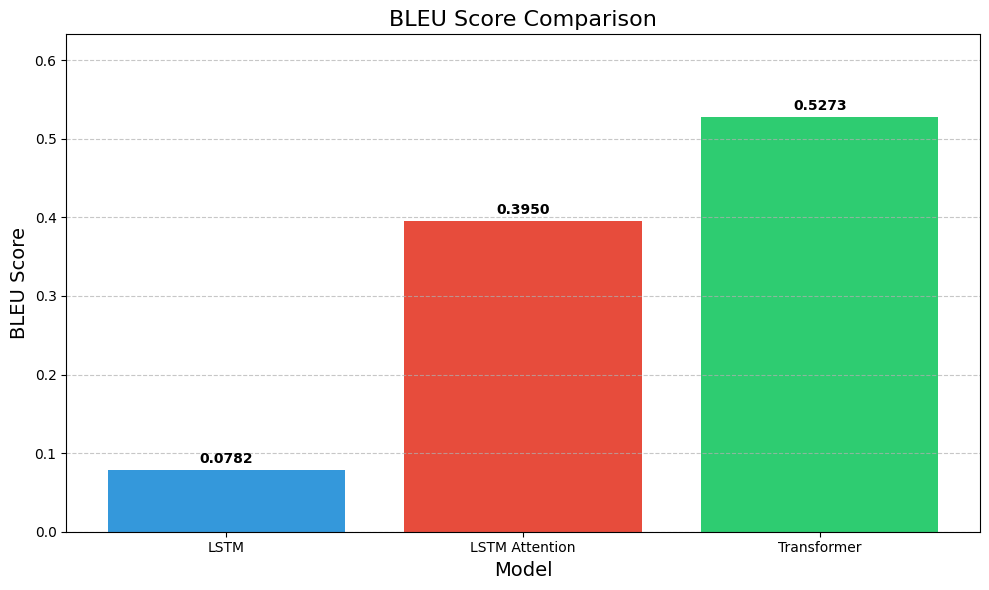

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(reference_texts, generated_texts):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    smoothie = SmoothingFunction().method4
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        # Skip jika ada yang NaN atau bukan string
        if not isinstance(ref, str) or not isinstance(gen, str):
            continue
        score = sentence_bleu([ref.lower().split()], gen.lower().split(), smoothing_function=smoothie)
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0.0


def plot_bleu_comparison(bleu_scores, model_names, title="BLEU Score Comparison"):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, bleu_scores, color=['#3498db', '#e74c3c', '#2ecc71'])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.ylim(0, max(bleu_scores) * 1.2)
    plt.title(title, fontsize=16)
    plt.ylabel('BLEU Score', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    return plt



df = pd.read_csv('result_news_articles.csv')

bleu_lstm = compute_bleu(df['title'], df['lstm_title_generated'])
bleu_lstm_attention = compute_bleu(df['title'], df['lstm_attention_title_generated'])
bleu_transformer = compute_bleu(df['title'], df['transformer_title_generated'])


print(f"BLEU Score - LSTM: {bleu_lstm:.4f}")
print(f"BLEU Score - LSTM Attention: {bleu_lstm_attention:.4f}")
print(f"BLEU Score - Transformer: {bleu_transformer:.4f}")


bleu_scores = [bleu_lstm, bleu_lstm_attention, bleu_transformer]
model_names = ['LSTM', 'LSTM Attention', 'Transformer']
plot_bleu_comparison(bleu_scores, model_names)
plt.show()